In [2]:
from __future__ import unicode_literals
from hazm import *
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from arabic_reshaper import reshape
from bidi.algorithm import get_display

In [3]:
STOP_WORDS_FILE = 'stop_words.txt'
NGRAM = 1
trainData = pd.read_csv("train.csv")
testData = pd.read_csv("test.csv")
labels = trainData['label'].unique()
print(labels)
display(trainData['label'].value_counts())

['فناوری' 'ورزشی' 'حوادث' 'سلامت' 'سیاسی' 'فرهنگی/هنری']


فناوری         1500
ورزشی          1500
حوادث          1500
سلامت          1500
سیاسی          1500
فرهنگی/هنری    1500
Name: label, dtype: int64

<div dir='rtl'>
ابتدا لیست لیبل ها را دخیره می کنیم  و سپس تعداد داده هایی که متعلق به هر داده است را چاپ می کنیم. همانطور که می بینیم تعدا تکرار برای هر لیبل یکسان است. اگر اینطور نبود و داده های مربوط به یک لیبل تعداد بسیار کمتری نسبت به بقیه ی لیبل ها داشت ممکن بود این مشکل پیش بیاید که داده هایی که مربوط به آن دسته از لیبل باشند به خوبی پیش بینی نشوند.  </br>

</div>

In [4]:
class StopWordsProcess:

    def __init__(self, doesStemming=False, doesLemmatize=True):
        self.stopWords = []
        self.stemmer = Stemmer()
        self.lemmatizer = Lemmatizer()
        self.doesStemming = doesStemming
        self.doesLemmatize = doesLemmatize
    def normalize(self):
        if self.doesStemming:
            self.stopWords = list(map(self.stemmer.stem, self.stopWords))
        if self.doesLemmatize:
            self.stopWords = list(map(self.lemmatizer.lemmatize, self.stopWords))

    def getStopWords(self):
        with open(STOP_WORDS_FILE, encoding="utf-8") as f:
            self.stopWords = [word.replace('\u200c', ' ').strip() for word in f if word]
        self.stopWords.append('\n')
        self.stopWords.append('\r')
        self.stopWords.append('\xA0')
        self.normalize()
        return self.stopWords


<div dir='rtl'>
ایست واژه ها در زبان فارسی در فایل
stop_words.s
ذخیره شده‌اند و ما به ازای هر خط از این فایل (که شامل یک ایست واژه است) عملیات 
strip
را روی آن انجام می‌دهیم؛ این تابع رشته بدون هیچ اسپیسی در ابتدا یا انتهایش را به ما برمی‌گرداند. سپس به لیست ایست‌ واژه‌ها 
'\r' , '\n'
را نیز اضافه می‌کنیم.
 توابع دیگر این کلاس در ادامه توضیح داده خواهد شد.
</div>

<h1>#Phase 1 (Preprocessing Data)</h1>

In [5]:
normalizer = Normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()
print("examples of stemmer:")
print(stemmer.stem("روم"))
print(stemmer.stem("بروم"))
print(stemmer.stem("رفتند"))
print(stemmer.stem("رفتیم"))
print(stemmer.stem("رفتن"))

print("examples of lemmatizer:")
print(lemmatizer.lemmatize("رو"))
print(lemmatizer.lemmatize("بروم"))
print(lemmatizer.lemmatize("رفتند"))
print(lemmatizer.lemmatize("رفتیم"))
print(lemmatizer.lemmatize("رفتن"))
print(lemmatizer.lemmatize("خواندنی"))
print(lemmatizer.lemmatize("کتابها"))

print("examples of normalizer:")
normalizer.normalize ( 'اصلاح نویسه ها و استفاده از نیم فاصله پردازش را آسان می کند' )



examples of stemmer:
رو
برو
رفتند
رفت
رفتن
examples of lemmatizer:
رو
رفت#رو
رفت#رو
رفت#رو
رفتن
خواندنی
کتاب
examples of normalizer:


'اصلاح نویسه\u200cها و استفاده از نیم فاصله پردازش را آسان می\u200cکند'

**Question 1**

<div dir='rtl'>
استفاده از 
stemming
پسوندهایی که بدون معنی هستند را از انتهای کلمه حذف می کند تا لغاتی که معنای نزدیک به هم دارند یک لغت در نظر گرفته شوند. البته همانطور که می بینیم در اینجا 
stemming
آنقدر موفق عمل نکرده و انتهای کلمه ای مانند رفتند را حذف نکرده است.   </br>
lemmatization
بن مضارع و بن ماضی فعل داده شده را برمیگرداند یعنی درواقع پسوندها و پیشوندهایی که معنا ندارند را حذف می کند چون کلماتی که ریشه آنها یا به عبارتی بن ماضی و مضارع آنها یکسان است از نظر معنایی در یک دسته قرار می گیرند.
در کلماتی که فعل نیستند، ریشه را برمیگرداند مثل تبدیل کتابها به کتاب و مثال‌هایی مانند این </br>
normalizer
در واقع به طور کلی به یک جمله نگاه می کند و آن را نرمال می کند مثلا در جمله داده شده از نیم فاصله استفاده نشده بود و با نرمال کردن آن اسپیس در جاهایی که لازم بود به نیم فاصله تبدیل شد. این ابزار زمانی بکار گرفته می شود که پردازش روی جمله های داده انجام می شود و نه فقط کلمات داده به صورت تکی. </br>

</div>

In [6]:
replacement = { 'stem' : False , 'lem' : True}

def replacmentInWords(words):
    if replacement['stem']:
        words  = list(map(stemmer.stem, words))
    if replacement['lem']:
        words  = list(map(lemmatizer.lemmatize, words))
    return words
ss = StopWordsProcess(doesStemming=replacement['stem'], doesLemmatize=replacement['lem'])
stopWords = ss.getStopWords()
stopWords = set(stopWords)



<div dir='rtl'>

replacement
که نشان می‌دهد هرکدام از عملیات 
lemmatization, stemming
روی داده‌ها انجام می‌شوند یا خیر را به
تابع پاس می‌دهیم و جایگزینی ایست واژه‌ها را انجام می‌دهیم و در نهایت یک ست از آنها که عضو تکراری ندارد را در ایست واژه ها می‌ریزیم. </br>
</div>

In [7]:
def preProcessOnEachContent(content):
    contentWithoutSemiSpaces = str(content).replace('\u200c', ' ')
    words = word_tokenize(contentWithoutSemiSpaces)
    words = replacmentInWords(words)
    words = [word for word in words if word not in stopWords]
    return words

In [8]:
trainRows = trainData.shape[0]
testRows = testData.shape[0]

def preProcess():
    trainDataContentWords = [[] for i in range(trainRows)]
    testDataContentWords = [[] for i in range(testRows)]
    trainDataLabels = [0 for i in range(trainRows)]
    testDataLabels = [0 for i in range(testRows)]

    i = 0
    for index, row in trainData.iterrows():
        trainDataContentWords[i] = preProcessOnEachContent(row['content'])
        trainDataLabels[i] = row['label']
        i += 1
    i = 0
    for index, row in testData.iterrows():
        testDataContentWords[i] = preProcessOnEachContent(row['content'])
        testDataLabels[i] = row['label']
        i += 1
    return trainDataContentWords, trainDataLabels, testDataContentWords, testDataLabels
    
trainDataContentWords, trainDataLabels, testDataContentWords, testDataLabels = preProcess()


<div dir='rtl'>
در تابع
preProcessOnEachcontent 
ابتدا نیم‌فاصله را با فاصله جایگزین می‌کنیم و کلمات را در هر 
content
جدا کرده و جایگزینی 
lemmatiation 
را روی آن انجام می‌دهیم و ایست واژه‌ها را از آن حذف می‌کنیم؛ عملیات ذکر شده را به ازای هر سطر 
content
در داده‌ی تست و داده‌ی 
train
انجام می‌دهیم. </br>

</div>

<h1>#Phase 2 (Problem Process)</h1>

**Question 2**

$P(c|x) = \frac{P(x|c)  P(c)}{P(x)}$

<div dir='rtl'>
قانون بیز در بالا نشان داده شده است. در اینجا متغیرها به ظرح زیر هستند: </br>

P(c|x): 
احتمال اینکه لیبل خبر داده شده، 
c
باشد به شرط اینکه لغات 
x 
در 
content 
آن دیده شده باشد.
(Posterior Probability) </br>

P(c):
احتمال اینکه لیبل خبر،
c 
باشد.
(Class Prior Probability) </br>

P(x):
احتمال اینکه در 
content 
خبر، لغات 
x 
دیده شود. 
(Evidence) </br>

P(x|c):
احتمال اینکه لغات 
x 
در لیبل 
c
 دیده شوند. 
 (Likelihood) </br>

از فرض 
naive bayes 
استفاده می‌کنیم که در آن حضور یک ویژگی مشخص در یک کلاس مستقل از حضور ویژگی‌های دیگر در آن است. در واقع در اینجا احتمال وجود یک لغت در متن یک خبر را مستقل از وجود لغت‌های دیگر در نظر می‌گیریم؛ همانطور که می‌دانیم این شرط برای سادگی در اینجا در نظر گرفته شده است و در واقعیت اینطور نیست. پس باید احتمال هریک از لغاتی که در 
x
وجود دارند را محاسبه کنیم؛ برای اینکار فرمول 
P(c|x) 
به صورت رو به رو در می‌آید: 
P(c|x) = P(x<sub>1</sub>|c) P(x<sub>1</sub>|c) P(x<sub>2</sub>|c)...P(x<sub>n</sub>|c) 
که 
x<sub>i</sub> 
در اینجا زنجیره‌ای از لغات به هم چسبیده و یا یک لغت است. </br>
در این مساله نیازی به محاسبه 
P(x) 
نیست چون این مقدار برای تمامی حالات یکسان است و تاثیری ندارد؛ برای محاسبه 
P(x|c) 
همانطور که گفته شد هر یک از لغات موجود در 
x 
را در نظرمی ‌گیریم و تعداد تکرار آنها را در هر لیبل محاسبه می‌کنیم تا احتمال بدست آید. (به جای ضرب احتمال از جمع لگاریتم آنها استفاده می‌کنیم تا اعداد بسیار کوچک نشوند.) در نهایت برای محاسبه 
P(c) 
در بین داده‌ی 
train 
تعداد داده هایی که در هر لیبل قرار دارند را به تعداد کل داده‌ها تقسیم می‌کنیم؛ در این مورد نیز به جای ضرب این احتمال در 
P(x|c) 
ار جمع لگاریتم آنها استفاده می‌کنیم. 
</div>




**Question 3**

<h3>Bigram</h3>
<div dir='rtl'>
تولید کردن 
ngram
ها مقدار اطلاعات ما از متن را افزایش می‌دهد. در زیر دو مثال دیده می‌شود که کلمه 
"شیر" 
در آنها معنی متفاوتی دارد: </br>
آوا شیر را خورد. </br>
شیر آوا را خورد. </br>
با استفاده از 
bigram 
در جمله‌های بالا، فیچرهای جمله اول تبدیل به آوا شیر، شیر را، را خورد می شود و فیچرهای دوم تبدیل به شیر آوا، آوا را، را خورد می‌شود؛ همانطور که می‌بینیم استفده از 
bigram 
باعث شد فیچرهای به وجود آمده باهم متفاوت باشند درصورتی که اگر دو جمله را کلمه به کلمه باهم مقایسه می‌کردیم، عیننا مشابه یکدیگر می‌شدند. در واقع با توجه به محل قرارگیری هر کلمه توانستیم باعث تمییز معنای دو جمله از یکدیگر شویم. در مثال زده شده استفاده از 
bigram 
برای تشخیص معنی کافی است ولی ممکن است در مثال‌های دیگر مجبور به استفاده از 
ngram 
با 
n 
های بزرگتری شویم. </br>
یکی از مشکلاتی که 
ngram 
ها دارند این است که ممکن است باعث 
overfit 
کردن  شود یعنی مدل ما نسبت یه مجموعه‌ای از فیچرهایی که 
ngram 
تشکیل داده است حساس می‌شود و ممکن است فیچرهای داده‌س تست را به خوبی تشخیص ندهد به همین دلیل در این پروژه تصمیم بر این شد که از 
bigram 
استفاده نشود. </br> 
</div>

In [9]:
def generateNgram(words, n=1):
    ngrams = []
    for i in range(len(words) - n + 1):
        ngrams.append(tuple(words[i:i+n]))
    return ngrams

<div dir='rtl'>
در تابع بالا 
ngram 
ها را با 
n 
دلخواه تولید می‌کنیم و آنها را در لیستی ریخته و ریترن می‌کنیم. </br>

</div>

In [10]:
def countWordsFreq(trainDataContentWords, trainDataLabels, n=1):
    ngramDict = {}
    totalCount = { label : 0 for label in labels}
    labelsWords = { label : set() for label in labels}
    for i in range(trainRows):

        ngrams = generateNgram(trainDataContentWords[i], n)
        for ngram in ngrams:
            labelsWords[trainDataLabels[i]].update(ngram)
            if trainDataLabels[i] not in ngramDict:
                ngramDict[trainDataLabels[i]] = {}
            if ngram not in ngramDict[trainDataLabels[i]]:
                ngramDict[trainDataLabels[i]][ngram] = 1
            else:
                ngramDict[trainDataLabels[i]][ngram] += 1
            totalCount[trainDataLabels[i]] += 1
    return ngramDict, totalCount, labelsWords

<div dir='rtl'>
در تابع بالا تعداد لغات تکرار شده به ازای هر لیبل را بدست می‌آوریم؛ درصورتی که آن لغت در آن لیبل وجود نداشت تعداد تکرار آن را برابر با 1 و در غیر این صورت یک واحد به تعداد قبلی آن اضافه می‌کنیم. </br>

</div>

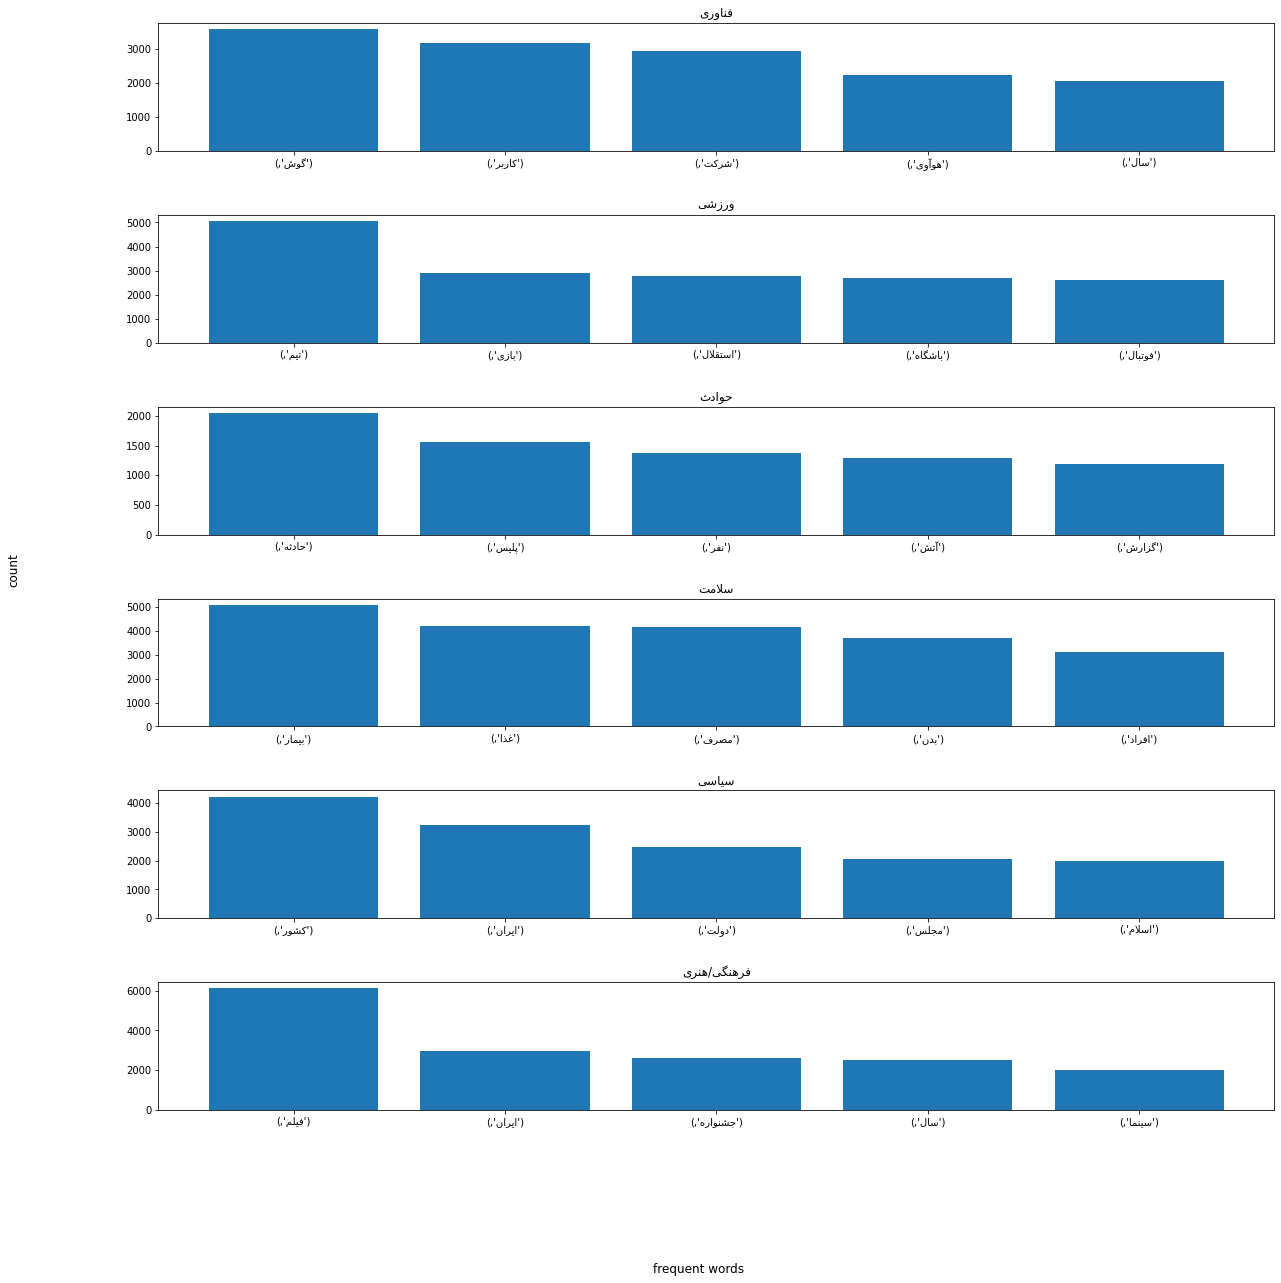

In [11]:
def plotFrequentWords(ngramDict, frequentWordsCount=5):
    figure , axis = plt.subplots(nrows=len(labels), ncols=1, figsize=(20, 20))
    figure.subplots_adjust(hspace=0.5)
    figure.supxlabel('frequent words')
    figure.supylabel('count')
    for i in  range(len(labels)):
        label = labels[i]
        frequentWords = dict(sorted(ngramDict[label].items(), key=lambda item: item[1], reverse=True)[:frequentWordsCount])
        keys = list(get_display(reshape(str(key)))for key in frequentWords.keys())
        values = list(frequentWords.values())
        axis[i].bar(keys, values)
        axis[i].set_title(get_display(reshape(label)))
    plt.show()

ngramDict , totalCount, labelsWords = countWordsFreq(trainDataContentWords, trainDataLabels, 1)
plotFrequentWords(ngramDict, 5)

**Question 6**

<div dir='rtl'>
در بالا نمودار و محاسبه فرکانس فیچرها به ازای 
n = 1 
انجام شده است

</div>

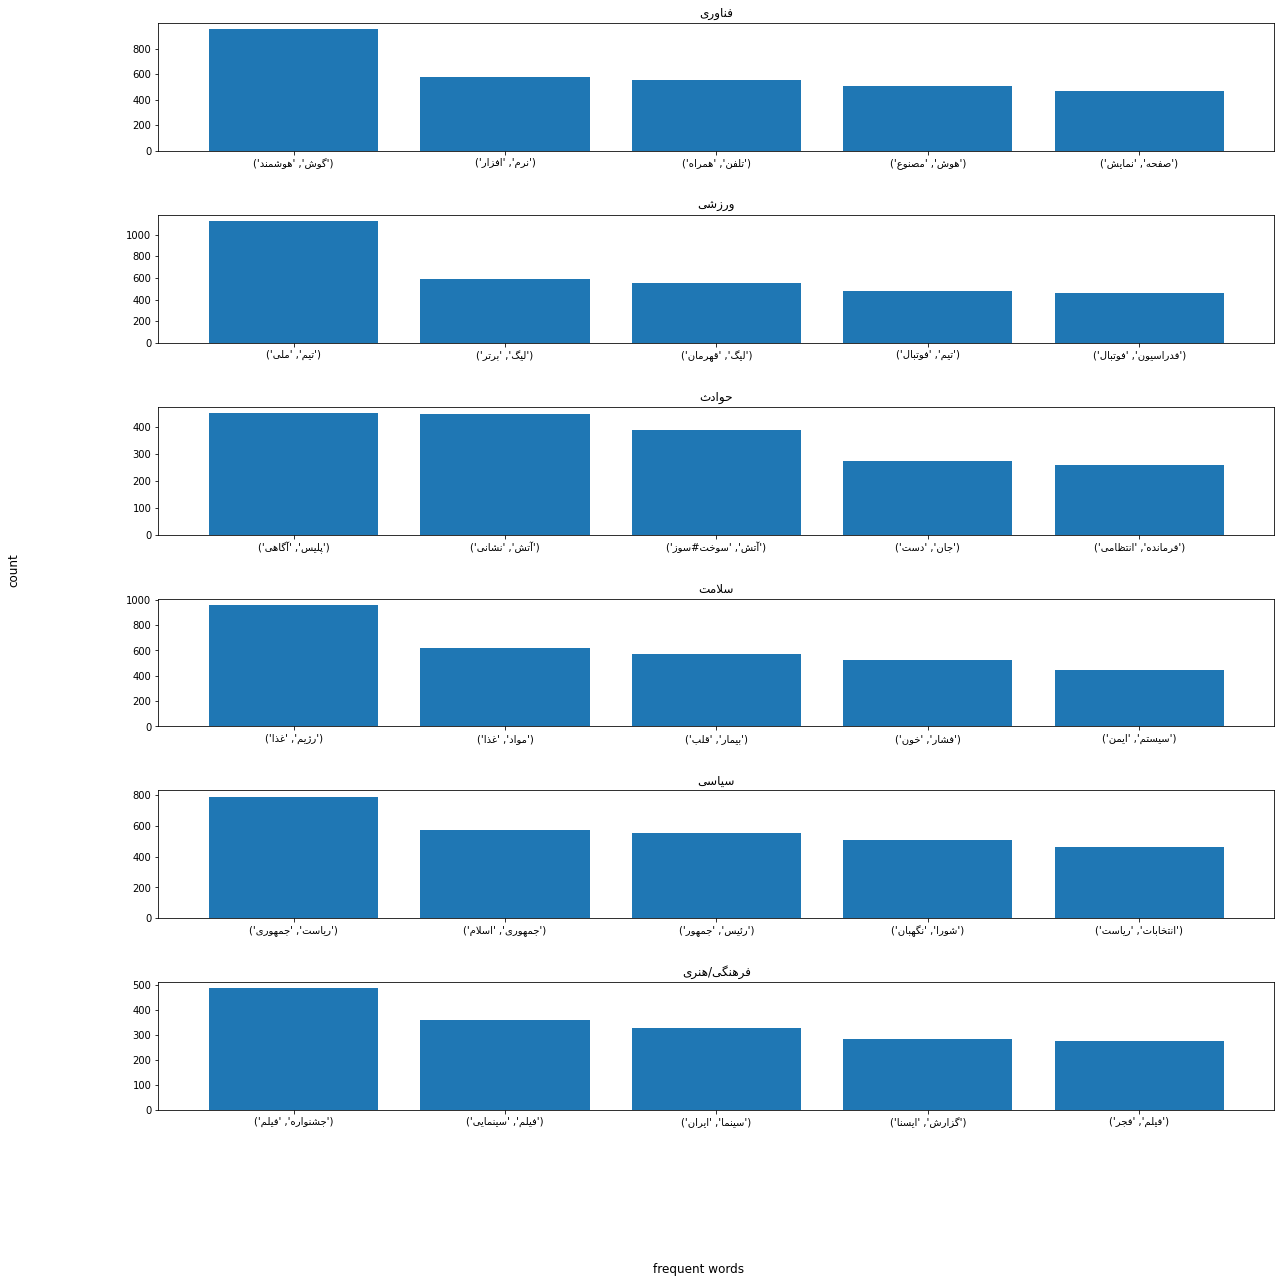

In [12]:
bigramDict , totalCountBigram, labelsWordsBigram = countWordsFreq(trainDataContentWords, trainDataLabels, 2)
plotFrequentWords(bigramDict, 5)

<div dir='rtl'>
در بالا نمودار و محاسبه فرکانس فیچرها به ازای 
n = 2
انجام شده است

</div>

<div dir='rtl'>
همانطور که می‌بینیم لغات "ایسنا"، "سال"، "ایران"، "کشور" لغات پرتکراری هستند که نمی‌توان آنها را به لیبل خاصی نسبت داد پس اقدام به حذف آنها می‌کنیم و آنها را در ایست واژه‌ها اضافه می‌کنیم و همچنین لغا گوشی به صوزت گوش آمده است چون آن را لملتایز کرده ایم پس آن را نیز اضافه می‌کنیم. </br>
</div>

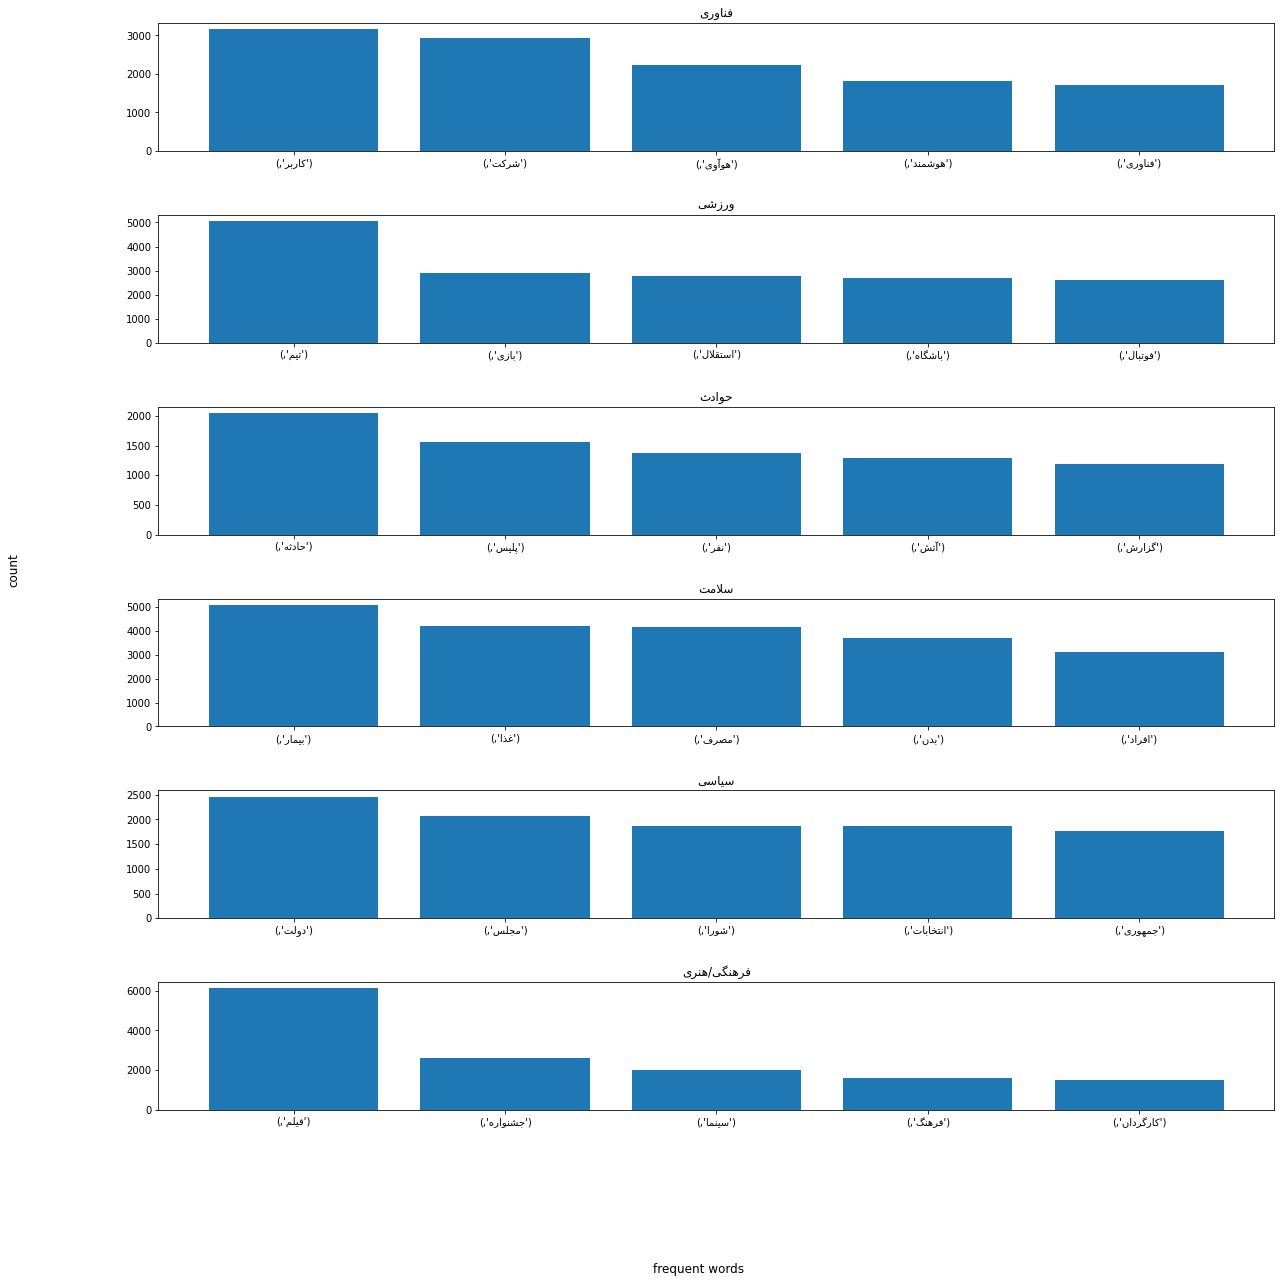

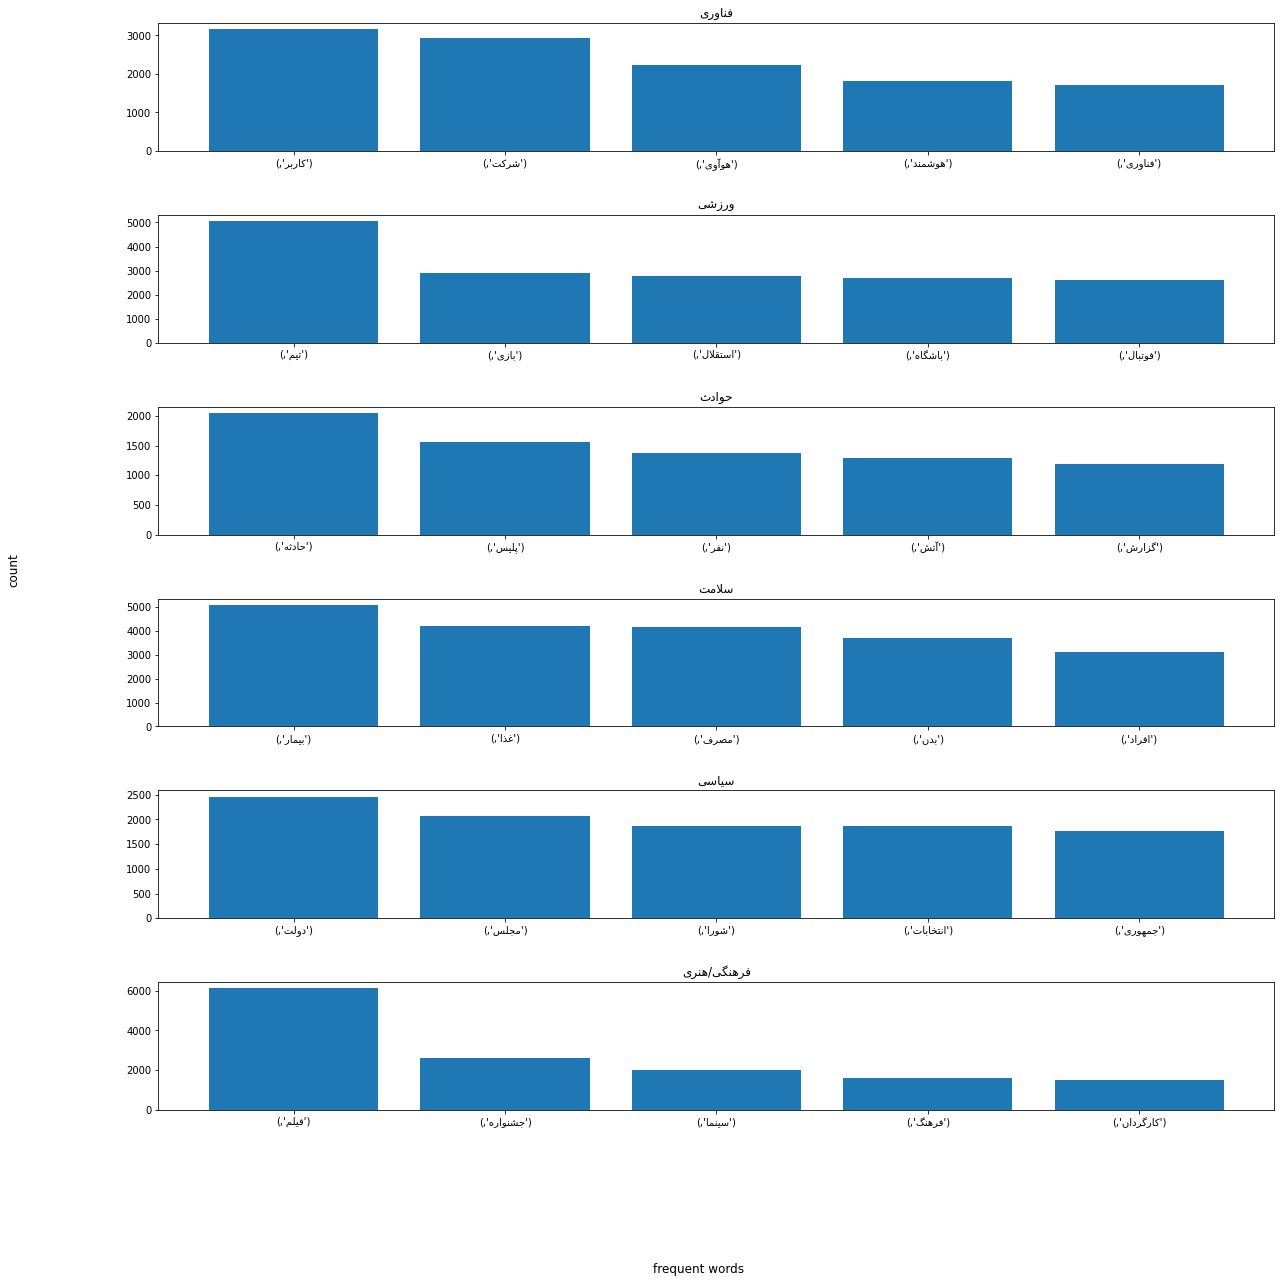

In [13]:
stopWords.update(['سال', 'ایران', 'کشور', 'ایسنا', 'اسلام', 'گوش'])
trainDataContentWords, trainDataLabels, testDataContentWords, testDataLabels = preProcess()
ngramDict , totalCount, labelsWords = countWordsFreq(trainDataContentWords, trainDataLabels, 1)
plotFrequentWords(ngramDict, 5)
ngramDict , totalCount, labelsWords = countWordsFreq(trainDataContentWords, trainDataLabels, NGRAM)
plotFrequentWords(ngramDict, 5)


<h3>Additive Smoothing</h3>

**Question 4**

<div dir='rtl'>
همانطور که توضیح داده شد، 
naive bayes 
به گونه‌ای طراحی شده است که درصورتی که یک فیچر تنها در یک لیبل وجود داشته باشد و در لیبل‌های دیگر وجود نداشته باشد، اگر داده‌ی تست آن فیچر وجود داشته باشد، به طور قطعی تشخیص می‌دهد که مربوط به آن لیبلی است که آن فیچر را دارد؛ در واقع احتمال وجود داشتن فیچر 
x 
درصورتی که لیبل 
c 
باشد را برابر صفر در نظر می‌گیرد. 
P(x|c) = 0 
و در نتیجه طبق قانون بیز و تناسب داشتن 
P(c|x) 
با 
P(x|c)
،
پس 
P(c|x)
نیز برابر با 0 می‌شود، یعنی احتمال لیبل 
c 
داشتن درصورتی که فیچر 
x
وجود داشته باشد. </br>

</div>

**Question 5**

$p_i= \frac{(x_i + \alpha)}{N + \alpha d}$
<div dir='rtl'>
می‌توان برای حل مشکل گفته شده احتمال را به صورت بالا محاسبه کرد که در اینجا 
x<sub>i</sub>
تعداد تکرار لغت و 
N 
تعداد کل و 
d 
تعدادفیچرها در تست وآلفا، درجه
smoothing 
است. اگر آلفا عددی غیر از 0 باشد صورت کسر هیچ‌گاه صفر نمی‌شود و احتمال به جای عدد 0 عدد کوچک غیرصفری می‌شود. برای مساله ما باید این احتمالات را در هم ضرب کنیم که با اینکار اعداد بدست آمده بسیار کوچک و نزدیک به هم می‌شوند و مقایسه آنها مشکل و با خطا مواجه می‌شود؛ برای برطرف کردن این مشکل، ما از احتمالات لگاریتم می‌گیریم و به جای ضرب آنها، جمع لگاریتم‌های آنها را محاسبه می‌کنیم. </br>   

</div>

In [14]:
def calcSumLogProbability(ngramDict, totalCount, ngrams, label, alpha = 0):
    sumProb = 0
    for ngram in ngrams:
        if ngram in ngramDict[label]:        
            sumProb += np.log((ngramDict[label][ngram] + alpha) / (totalCount[label] + alpha * len(labelsWords[label])))
        elif alpha == 0:
            sumProb += np.log(10**-90)
        else:
            sumProb += np.log((alpha) / (totalCount[label] + alpha * len(labelsWords[label])))

    return sumProb

In [15]:
allLabelsDatasCount = np.sum(list(trainData['label'].value_counts()))
allLabelsCountTest = np.sum(list(testData['label'].value_counts()))
labelsDataCount = dict()
labelsDataTestCount = dict()
for label in labels:
    labelsDataCount[label] = trainData['label'].value_counts()[label]
    labelsDataTestCount[label] = testData['label'].value_counts()[label]
calcPriorProb = lambda label : labelsDataCount[label] / allLabelsDatasCount
calcPriorTestProb = lambda label : labelsDataTestCount[label] / allLabelsCountTest

<div dir='rtl'>
در تابع نوشته شده احتمال هر لیبل مشخص می‌شود که در واقع در بیز همان 
Class Prior Probability 
است. در این مساله چون تعداد داده برای هر لیبل برابر است این احتمال برای همه‌ی لیبل‌ها برابر است. </br>

</div>

In [16]:
def predictLabels(testDataContentWords, ngramDict, totalCount, alpha = 0):
    predictedLabels = []
    for i in range(testRows):
        ngrams = generateNgram(testDataContentWords[i], NGRAM)
        maxProb = -np.inf
        maxLabel = ''
        for label in labels:
            sumProb = calcSumLogProbability(ngramDict, totalCount, ngrams, label, alpha)
            priorProb = calcPriorProb(label)
            prob = sumProb + np.log(priorProb)
            if prob > maxProb:
                maxProb = prob
                maxLabel = label
        predictedLabels.append(maxLabel)
    return predictedLabels
predictedWithoutSmoothing = predictLabels(testDataContentWords, ngramDict, totalCount, 0)

<h1>#Phase 3 (Testing)</h1>

**Question 7**
<div dir='rtl'>
precision 
بیان می‌کند نسبت تعداد خبرهایی که به درستی در دسته بندی موردنظر تشخیص داده شده‌اند به تعداد تمام خبرهایی که تشخیص داده شده‌اند (چه درست و چه غلط) چقدر است؛ 
recall 
نسبت تعداد خبرهایی که به درستی در دسته بندی مورد نظر تشخیص داده شده‌اند را به تعداد تمام خبرهایی که در مجموعه داده تست در آن دسته بندی خاص قرار دارند، نشان می‌دهد. در واقع 
recall 
توانایی یافتن تمام نمونه‌های مرتبط یک کلاس را در مجموعه داده بیان می‌کند ولی  
precision 
نسبت تعداد تشخیص‌های درست به کل تشخیص‌های داده شده برای یک کلاس را به ما می‌دهد. با کمی دقت درمی‌یابیم که 
recall 
و
precision 
مخالف یکدیگر عمل می‌کنند و درواقع بالا رفتن یکی باعث کم شدن مقدار دیگری می‌شود و باید ترکیبی از این دو که همان 
F1
است برای بررسی داده استفاده شود. </br>
مثالی را در نظر بگیرید که تنها لیبل یک خبر را بررسی کردیم و این لیبل را درست تشخیص داده‌ایم؛ در این مثال 
precision 
ما برابر با 1 خواهد بود درحالی که 
recall 
مقدار ناچیزی دارد. (در واقع ممکن است با بررسی داده‌های دیگر و لیبل زدن روی آنها ممکن است به این نتیجه برسیم که الگوریتم ما کارکرد خوبی ندارد پس 
precision 
به تنهایی نمی‌تواند معیار مناسبی باشد.)
در مثالی دیگر فرض کنین لیبل تمامی داده‌های تست را یک لیبل خاص (مثلا 
c)
پیش بینی کرده‌ایم، در اینصورت مقدار 
recall 
برابر با 1 و مقدار 
precision 
ناچیز خواهد بود؛ پس 
recall 
نیز به تنهایی نمی‌تواند به تنهایی معیار مناسبی باشد.

</div>

**Question 8**

$mean = \frac{n}{\frac{1}{x_1} + \frac{1}{x_2} + ... + \frac{1}{x_n}}$
<div dir='rtl'>
در 
F1 
از میانگین هارمونیک استفاده می‌شود که فرمول آن در بالا نشان داده شده است؛ اگر در این فرمول 
n 
را برابر با 2 قرار دهیم به فرمول 
F1 
می‌رسیم. همانطور که توضیح داده شد 
recall 
و 
precison 
عکس یکدیگر عمل می‌کنند و بالا رفتن یکی سبب پایین آمدن دیگری می‌شود پس ما باید نوعی از میانگین را انتخاب کنیم که اگر یکی از این دو مقدار ناچیزی داشت، مقدار میانگین نیز زیاد نشود. در زیر میانگین هندسی و میانگین حسابی و میانگین هارمونیک با دو احتمال 0.4 و 0.9 برای 
recall 
و
precision 
محاسبه شده است. </br>
 
 میانگین حسابی = 2/(0.4 + 0.9) = 0.65
</br>
میانگین هندسی = 0.6
</br>
میانگین هارمونیک = 0.55
</br>

</div>

**Question 9**


$Macro-F1 = \frac{F1_1 + F1_2 + ... + F1_n}{n}$ </br>
$Weighted-F1 = P(c_1)F1_1 +  P(c_2)F1_2 + ... +  P(c_n)F1_n $ </br>
$Micro-F1 = \frac{CorrectDetected}{AllDetected}$ </br>


<div dir='rtl'>
معیار 
F1 
تنها برای یک کلاس استفاده می‌شود درحالی که ممکن است دسته‌های مختلفی برای تصمیم‌گیری داشته باشیم؛ در این شرایط از سه معیاری که فرمول آنها در بالا آمده است برای ارزیابی کلی استفاده می‌کنیم. در 
Macro 
میانگین حسابی 
n 
تا از 
F1 
ها را بدست می‌آوریم؛ در 
Weighted-F1
میانگین وزن دار 
F1 
ها را محاسبه می‌کنیم. در واقع وزن هریک از آنها احتمال وجود داشتن آن لیبل در بیل لیبل‌های داده‌ی تست است. معیار 
Micro-F1 
تعداد تمامی پیش بینی‌های درست به تعداد کل پیش بینی ها را بیان می‌کند. 
</div>

In [17]:
def calPredictedLabelProb(predicted):
    predictedLabelsCount = dict()
    for label in labels:
        predictedLabelsCount[label] = 0
    for label in predicted:
        predictedLabelsCount[label] += 1 / len(predicted)
    return predictedLabelsCount

In [18]:
def validatePrediction(predicted):

    rowsNames = ['Precision', 'Recall', 'F1-score', 'Accuracy', 'Macro Avg', 'Micro Avg', 'Weighted Avg']
    columnsNames = np.append(labels, 'All Classes')
    valuationTable = pd.DataFrame(columns=columnsNames, index=rowsNames)
    F1 = { label : 0 for label in labels}
    correctDetected = 0
    weightedAvg = 0
    allDetected = 0
    total =  np.sum(list(testData['label'].value_counts()))
    for label in labels:
        totalClass = testData['label'].value_counts()[label]
        correctDetectedClass = 0
        allDetectedClass = 0
        for i in range(testRows):
            if testData['label'][i] == label and testData['label'][i] == predicted[i]:
                correctDetectedClass += 1
            if predicted[i] == label:
                allDetectedClass += 1
        allDetected += allDetectedClass
        correctDetected += correctDetectedClass
        precision = correctDetectedClass / allDetectedClass
        recall = correctDetectedClass / totalClass
        F1[label] = 2 * precision * recall / (precision + recall)
        valuationTable[label]['Precision'] = precision * 100
        valuationTable[label]['Recall'] = recall * 100
        valuationTable[label]['F1-score'] = F1[label] * 100
        weightedAvg += calcPriorTestProb(label) * F1[label] 
    valuationTable['All Classes']['Accuracy'] = correctDetected / total * 100
    valuationTable['All Classes']['Macro Avg'] = np.mean(list(F1.values())) * 100
    valuationTable['All Classes']['Micro Avg'] = correctDetected / allDetected * 100
    valuationTable['All Classes']['Weighted Avg'] = weightedAvg * 100
    valuationTable.fillna('-', inplace=True)
    return valuationTable

        
withoutSmoothingvaluationTable = validatePrediction(predictedWithoutSmoothing)
predictedWithSmoothing = predictLabels(testDataContentWords, ngramDict, totalCount, 1)
withSmoothingvaluationTable = validatePrediction(predictedWithSmoothing)

**Question 10**

<div dir='rtl'>
جدول مقادیر خواسته شده به ازای زمانی که از 
Additive Smoothing 
استفاده نمی‌کنیم و آلفا برابر با 1 است در زیر نمایش داده شده است:

</div>

In [19]:
withoutSmoothingvaluationTable

,فناوری,ورزشی,حوادث,سلامت,سیاسی,فرهنگی/هنری,All Classes
Precision,89.69697,98.816568,94.444444,94.011976,78.440367,68.376068,-
Recall,88.095238,87.894737,76.5,88.700565,85.5,88.888889,-
F1-score,88.888889,93.036212,84.530387,91.27907,81.818182,77.294686,-
Accuracy,-,-,-,-,-,-,85.73991
Macro Avg,-,-,-,-,-,-,86.141237
Micro Avg,-,-,-,-,-,-,85.73991
Weighted Avg,-,-,-,-,-,-,86.053243


<div dir='rtl'>
جدول مقادیر خواسته شده به ازای زمانی که از 
Additive Smoothing 
استفاده می‌کنیم و آلفا برابر با 0 است در زیر نمایش داده شده است:

</div>

In [20]:
withSmoothingvaluationTable

,فناوری,ورزشی,حوادث,سلامت,سیاسی,فرهنگی/هنری,All Classes
Precision,96.296296,98.924731,90.186916,96.551724,90.047393,95.833333,-
Recall,92.857143,96.842105,96.5,94.915254,95.0,89.444444,-
F1-score,94.545455,97.87234,93.236715,95.726496,92.457421,92.528736,-
Accuracy,-,-,-,-,-,-,94.349776
Macro Avg,-,-,-,-,-,-,94.394527
Micro Avg,-,-,-,-,-,-,94.349776
Weighted Avg,-,-,-,-,-,-,94.364996


**Question 11**

<div dir='rtl'>
همانطور که می‌بینیم با استفاده از 
Additive Smoothing 
اغلب درصدها افزایش یافت؛ همانطور که پیش تر ذکر شد استفاده از 
Additive Smoothing 
باعث می‌شود تا به جای استفاده از احتمال 0، از احتمال بسیار کوچکی استفاده کنیم چون در صورت کسر احتمال با آلفا جمع می‌شود که مقدار آن 1 درنظر گرفته می‌شود. مورد دیگری که قابل توجه است تفاوت 
recall 
و 
precision 
است که زمانی که مقدار یکی کم است، مقدار دیگری بالا است و دلیل این نیز پیش تر ذکر شده است و 
F1 
که معیار دقیقتری از 
recall 
و 
precision 
است،میانگینی از این دو مقدار را نمایش می‌دهد. </br>

</div>

In [21]:
testDataCopy = testData.copy()
testDataCopy['predicted'] = predictedWithSmoothing
testDataCopy['correct'] = testDataCopy['label'] == testDataCopy['predicted']
testDataCopy['correct'] = testDataCopy['correct'].apply(lambda x : '✓' if x else '✗')

count = 0
for i in range(testRows):
    if count == 5:
        break
    if testDataCopy['correct'][i] == '✗':
        print('correct label: ',testDataCopy['label'][i])
        print('predicted label: ',testDataCopy['predicted'][i])
        print(testDataCopy['content'][i])  
        print('-------------------------------------')
        count += 1

# testDataCopy.head(5)

correct label:  فرهنگی/هنری
predicted label:  سیاسی
اعتراض گسترده کاربران توییتر به اظهارات وزیر امورخارجه آمریکا هشتگ انگلیسی پرشین گلف (خلیج فارس) را در توییتر ترند کرد. به گزارش خبرآنلاین، رکس تیلرسون وزیر امورخارجه آمریکا در اظهارات اخیرش با به کار بردن واژه‌ای مجعول به جای خلیج فارس موجی از اعتراضات را در شبکه‌های اجتماعی برانگیخت. بسیاری از کاربران شبکه‌های اجتماعی به ویژه توییتر برای اعتراض به این موضوع از هشتگ انگلیسی «PersianGulf» استفاده کردند. همین موضوع سبب شد که این هشتگ مدتی در توییتر ترند شود.
-------------------------------------
correct label:  سیاسی
predicted label:  حوادث
وکیل مدافع نازنین زاغری متهم ایرانی - بریتانیایی از برگزاری دادگاه و اعلام ختم رسیدگی به دومین پرونده موکلش به اتهام فعالیت تبلیغی علیه نظام  در شعبه ۱۵ دادگاه انقلاب به ریاست قاضی صلواتی خبر داد.
-------------------------------------
correct label:  فرهنگی/هنری
predicted label:  ورزشی
- روز گذشته در حاشیه معرفی ساپینتو سر مربی باشگاه استقلال مصطفی آجورلو از یک خبر داد، مدیرعامل استقلال اعلام کرد شب

**Question 12**

<div dir='rtl'>
در خبر اول کلمه "وزیر امور خارجه" که به سیسات نزدیک است باعث به اشتباه تشخیص دادن خبر شد. در خبر دوم کلمه "ختم" که نزدیک به موضوع حوادث و مرگ است باعث اشتباه شد. در خبر سوم کلمه "سرمربی باشگاه" که به موضوع ورزشی نزدیک است باعث اشتباه در تشخیص شد و در خبر چهارم کلمه "وزیر وزارتحانه" باعث لیبل سیاسی شد. در خبر پنجم چون طول خبر بسیار کم بود و فقط شامل دو کلمه بود تشخیص با خطا روبه‌رو شد. در واقع چون در این مدل تنها بر اساس کلمات به پیش بینی لیبل هر خبر پرداختیم و بعضی کلمات با فرکانش بالایی در برخی لیبل‌ها وجود داشت باعث شد تا مدل ما با دیدن آن کلمه لیبل اشتباهی را تشخیص دهد. </br> 

</div>